***Mounting Google Drive***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Required Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report, confusion_matrix
from PIL import ImageFile
import cv2
ImageFile.LOAD_TRUNCATED_IMAGES = True

***Loading Train Data***

In [ ]:
# Reading the train labels from csv file and displaying first five rows

df = pd.read_csv('/content/drive/MyDrive/Project Models/trainLabels.csv',dtype = str)
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
# Training data Shape (Labels)

df.shape

(10000, 2)

In [ ]:
#  Train Labels Distribution

df['level'].value_counts()

0    7257
2    1585
1     731
3     240
4     187
Name: level, dtype: int64

**Note: While running the cells under Transfer Learning section some of the changes to be made for loading the data are as follows,**


1.   While loading the train and test data through 'flow from data frame' function, remove the parameter 'color_mode = grayscale' in the function.
2.   Also, do not apply any preprocessing to the data, as transfer learning takes input images with 3 channels (RGB).



In [ ]:
# Loading Train Data

def append_ext(fn):       #-----> This function appends the .jpeg extension to the names of the images in the csv file as the real images comes with a .jpeg extension.
  return fn+".jpeg"       #-----> for ex csv file talks about the image name as 10_left, but the actual image has 10_left.jpeg. In order to relate them correctly we append .jpeg extension.
                          
df["image"]=df["image"].apply(append_ext)   #---> Applying the defined function.

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_dataframe(dataframe = df, directory = '/content/drive/MyDrive/Project Datasets/train_set',
                                              x_col = 'image', y_col = 'level', class_mode = 'categorical', target_size = (256,256),
                                              batch_size = 10000, color_mode = 'grayscale') #--> This function combines the images wrt to their labels.

Found 10000 validated image filenames belonging to 5 classes.


In [ ]:

x, y = train_generator.next() # --> x contains images, y contains labels wrt to each image. Size of this x and y variable after one iteration would be equal to the batchsize mentioned in the above cell.


In [ ]:
# Training Data Shape

x.shape

(10000, 256, 256, 3)

***Note:***
1.   To display some sample train images without preprocessing, we must rescale the images using Image data generator.
2.   The below cell is only used to display the images used in the model.



Found 10000 validated image filenames belonging to 5 classes.


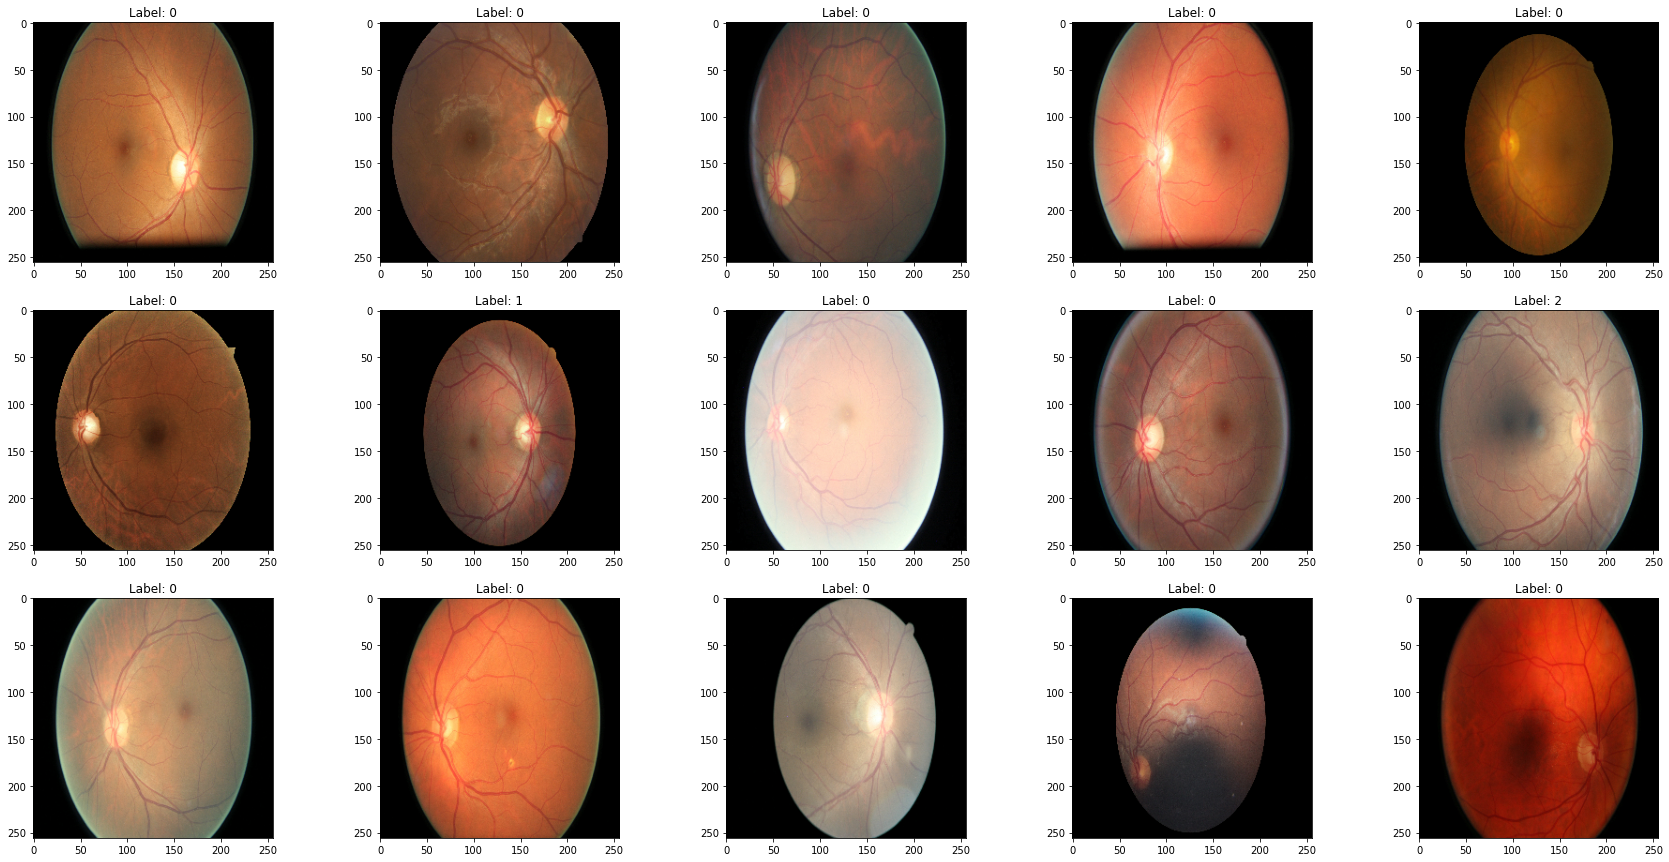

In [ ]:
def append_ext(fn):       
  return fn+".jpeg"      
                          
df["image"]=df["image"].apply(append_ext)

datagen1 = ImageDataGenerator(rescale=1./255)
train_generator1 = datagen1.flow_from_dataframe(dataframe = df, directory = '/content/drive/MyDrive/Project Datasets/train_set',
                                              x_col = 'image', y_col = 'level', class_mode = 'categorical', target_size = (256,256),
                                              batch_size = 20) #--> This function combines the images wrt to their labels.
x_dev , y_dev = train_generator1.next()

y_dev = y_dev.argmax(axis=1)  
plt.figure(figsize = (30,15))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(x_dev[i],cmap='gray')
  plt.title(f'Label: {y_dev[i]}')
plt.show()

***Image Preprocessing***

In [ ]:
def preprocessing_img(img):
  target_type_min=0
  target_type_max=255
  target_type = np.uint8
  imin = img.min()
  imax = img.max()
  a = (target_type_max - target_type_min) / (imax - imin)
  b = target_type_max - a * imax
  img1 = (a * img + b).astype(target_type)                  # Converting dtype of image to 'uint8' for further preprocessing
  img2 = cv.normalize(img1, img1, 0, 255, cv.NORM_MINMAX)   # Normalizing the image
  imgGray = img2                                                    
  clahe = cv.createCLAHE(clipLimit=7.0, tileGridSize=(8,8)) # To increase the contrast of the images for better visibility
  contrast = clahe.apply(imgGray)
  contrast_list = contrast.tolist()
  contrast_list = np.array(contrast_list, dtype='uint8')
  contrast_list=contrast_list.reshape(256,256,1)
  return contrast_list

In [ ]:
# Applying the defined preprocessing function to all the train images.

for i in range(len(x)):
  x_pro = preprocessing_img(x[i])      

Label: 0


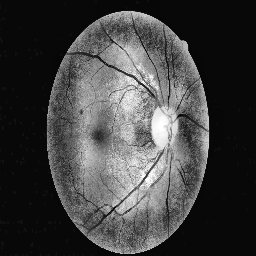


Label: 0


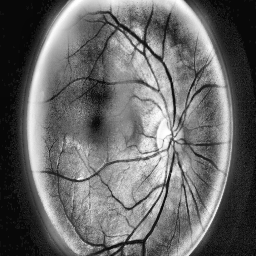


Label: 0


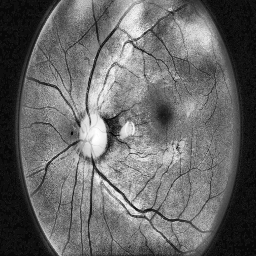


Label: 0


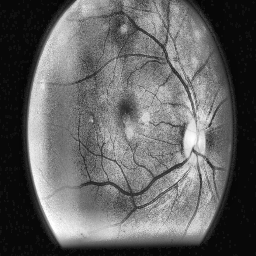


Label: 0


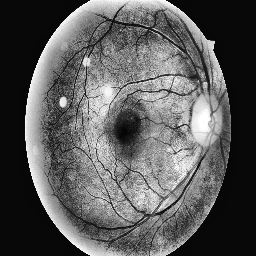

In [ ]:
y1 = y.argmax(axis=1)                     # Converting onehotencoded labels to its original format
                                                  
for i in range(5):                        # Displaying some sample train images
  print(f'Label: {y1[i]}')
  cv2_imshow(x_pro[i])
  print()

In [ ]:
#Displaying first 10 onehotencoded labels.

for i in range(10):
  print(y[i])

[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


***Loading Test Data***

In [ ]:
# Reading the test labels from csv file and displaying first five rows.

df1 = pd.read_csv('/content/drive/MyDrive/Project Models/testLabels.csv', dtype = str)
df1.head()

,image,level
0,40570_left,0
1,40570_right,1
2,40571_left,0
3,40571_right,0
4,40575_left,2


In [ ]:
# Testing data Shape

df1.shape

(3000, 2)

In [ ]:
#  Testing Labels Distribution

df1['level'].value_counts()

0    2252
2     418
1     219
3      56
4      55
Name: level, dtype: int64

In [ ]:
# Loading Test Data

def append_ext(fn):     #-----> This function appends the .jpeg extension to the names of the images in the csv file as the real images comes with a .jpeg extension.
  return fn+".jpeg"     #-----> for ex csv file talks about the image name as 10_left, but the actual image has 10_left.jpeg. In order to relate them correctly we append .jpeg extension.

df1["image"]=df1["image"].apply(append_ext)   #---> Applying the defined function.

datagen1 = ImageDataGenerator()
test_generator = datagen1.flow_from_dataframe(dataframe = df1, directory = '/content/drive/MyDrive/Project Datasets/test_set',
                                              x_col = 'image', y_col = 'level', class_mode = 'categorical', target_size = (256,256),
                                              batch_size = 3000, color_mode = 'grayscale')  #--> This function combines the images wrt to their labels.

Found 3000 validated image filenames belonging to 5 classes.


In [ ]:
x_test , y_test = test_generator.next()   # --> x contains images, y contains labels wrt to each image. Size of this x and y variable after one iteration would be equal to the batchsize mentioned in the above cell.

In [ ]:
# Test data shape

x_test.shape

(3000, 256, 256, 3)

In [ ]:
# Applying the defined preprocessing function to all the train images.

for i in range(len(x_test)):
  x_test[i] = preprocessing_img(x_test[i])

Label: 2


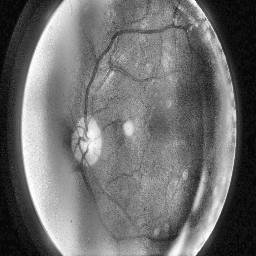


Label: 0


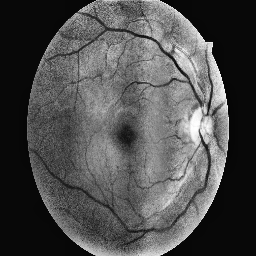


Label: 0


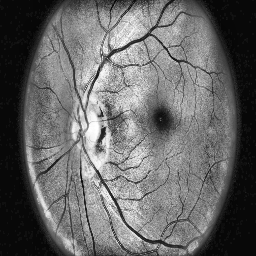

In [ ]:
# Displaying some sample test images

y_test1 = y_test.argmax(axis=1)
for i in range(3):
  print(f'Label: {y_test1[i]}')
  cv2_imshow(x_test[i])
  print()

***Convolutional Neural Network***

In [ ]:
# CNN Model

def dr_model(ishape = (256,256,1), ndim =5, lr = 1e-4):
  input_img  =  tf.keras.layers.Input(shape = ishape)
  conv1      =  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
  conv2      =  tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same')(conv1)
  drop1      =  tf.keras.layers.Dropout(0.5)(conv2)
  max1       =  tf.keras.layers.MaxPool2D((2,2))(drop1)
  conv3      =  tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(max1)
  conv4      =  tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')(conv3)
  drop2      =  tf.keras.layers.Dropout(0.5)(conv4)
  max2       =  tf.keras.layers.MaxPool2D((2,2))(drop2)
  flat       =  tf.keras.layers.Flatten()(max2)
  out        =  tf.keras.layers.Dense(ndim, activation='softmax')(flat)
  model      =  tf.keras.models.Model(inputs = input_img, outputs = out)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# Model Summary

model = dr_model()
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256, 256, 128)     0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 128, 128, 256)     295168    
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 512)     1180

In [ ]:
# Call backs

model_name = "dr_model.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, save_weights_only=True)

def scheduler(epoch, lr):
    if epoch%15==0:
      lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

***Defining Class Weights***

In [ ]:
from sklearn.utils import class_weight
y2 = y.argmax(axis=1)    
class_weights = class_weight.compute_class_weight('balanced',np.unique(y2),y2)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.27559597629874605,
 1: 2.735978112175103,
 2: 1.2618296529968454,
 3: 8.333333333333334,
 4: 10.695187165775401}

***CNN Model Training***

In [ ]:
# Model Training

history = model.fit(x_pro ,y, batch_size=32, epochs=15, callbacks= [model_check_point,early_stop,lr_schedule], validation_split=0.3, class_weight = class_weights_dict)

Epoch 1/15
219/219 [==============================] - 140s 630ms/step - loss: 75.8991 - accuracy: 0.2066 - val_loss: 1.5974 - val_accuracy: 0.1333
Epoch 2/15
219/219 [==============================] - 133s 608ms/step - loss: 1.5834 - accuracy: 0.1856 - val_loss: 1.6184 - val_accuracy: 0.1703
Epoch 3/15
219/219 [==============================] - 133s 608ms/step - loss: 1.4889 - accuracy: 0.2275 - val_loss: 1.5909 - val_accuracy: 0.1690
Epoch 4/15
219/219 [==============================] - 133s 608ms/step - loss: 1.4586 - accuracy: 0.2850 - val_loss: 1.5284 - val_accuracy: 0.1797
Epoch 5/15
219/219 [==============================] - 133s 608ms/step - loss: 1.3289 - accuracy: 0.2821 - val_loss: 1.4451 - val_accuracy: 0.2933
Epoch 6/15
219/219 [==============================] - 133s 607ms/step - loss: 1.1925 - accuracy: 0.3578 - val_loss: 1.3792 - val_accuracy: 0.3680
Epoch 7/15
219/219 [==============================] - 133s 608ms/step - loss: 1.1040 - accuracy: 0.4150 - val_loss: 1.4000 

In [ ]:
# Evaluating model for test data

model.load_weights(model_name)
model.evaluate(x_test,y_test)

94/94 [==============================] - 11s 113ms/step - loss: 1.0777 - accuracy: 0.6090


[1.0776820182800293, 0.609000027179718]

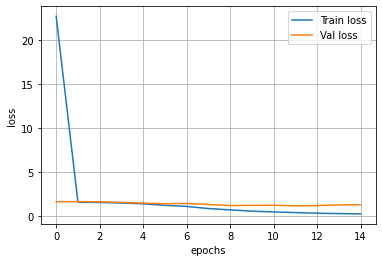

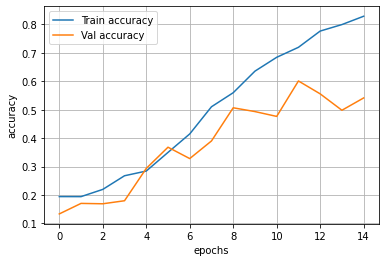

In [ ]:
# Train and Validation Loss Graph
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# Train and Validation Accuracy Graph
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Classification report

y_pred = model.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                            # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      2252
           1       0.12      0.05      0.08       219
           2       0.15      0.08      0.10       418
           3       0.07      0.02      0.03        56
           4       0.09      0.02      0.03        55

   micro avg       0.67      0.49      0.57      3000
   macro avg       0.24      0.16      0.19      3000
weighted avg       0.61      0.49      0.54      3000
 samples avg       0.49      0.49      0.49      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix
confusion_matrix(y_test1,y_pred1)

array([[1990,   69,  174,   11,    8],
       [ 193,   12,   14,    0,    0],
       [ 365,   15,   34,    2,    2],
       [  51,    1,    3,    1,    0],
       [  49,    0,    5,    0,    1]])

***Transfer learning (VGG-16)***

In [ ]:
# Call backs

model_name1 = "transfer_model.h5"

early_stop1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point1 = tf.keras.callbacks.ModelCheckpoint(model_name1, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [ ]:
# Loading the weights from VGG16 architecture

base_model = tf.keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(256, 256, 3),
    include_top=False) 
base_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Model without top layer

input_image = tf.keras.Input(shape=(256, 256, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(inputs = input_image, outputs =out)
print(model_tf.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 163845    
Total params: 14,878,533
Trainable params: 163,845
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
# Training the model without Top layer.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, epochs = 12, verbose = 1, callbacks= [early_stop1, model_check_point1], validation_split = 0.3)

Epoch 1/12
219/219 [==============================] - 48s 128ms/step - loss: 3.8182 - accuracy: 0.5546 - val_loss: 2.1583 - val_accuracy: 0.6377
Epoch 2/12
219/219 [==============================] - 24s 112ms/step - loss: 1.5341 - accuracy: 0.6637 - val_loss: 1.9896 - val_accuracy: 0.6737
Epoch 3/12
219/219 [==============================] - 24s 111ms/step - loss: 0.9821 - accuracy: 0.7468 - val_loss: 1.8947 - val_accuracy: 0.6110
Epoch 4/12
219/219 [==============================] - 24s 111ms/step - loss: 0.6614 - accuracy: 0.7911 - val_loss: 1.8573 - val_accuracy: 0.6147
Epoch 5/12
219/219 [==============================] - 24s 112ms/step - loss: 0.4845 - accuracy: 0.8431 - val_loss: 1.8991 - val_accuracy: 0.6103
Epoch 6/12
219/219 [==============================] - 24s 111ms/step - loss: 0.3245 - accuracy: 0.8798 - val_loss: 1.8786 - val_accuracy: 0.6033
Epoch 7/12
219/219 [==============================] - 24s 111ms/step - loss: 0.2655 - accuracy: 0.9116 - val_loss: 1.8299 - val_ac

In [ ]:
# Model with Top layer

base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256,256,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

# Model Training with Top layer.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.load_weights(model_name1)     #---> Loading the weights of the trained model without top layer.
                              
model_tf.fit(x, y, batch_size = 32, epochs = 5, verbose = 1, callbacks= [early_stop1, model_check_point1], validation_split = 0.3)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 163845    
Total params: 14,878,533
Trainable params: 14,878,533
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
219/219 [==============================] - 63s 285ms/step - loss: 0.1896 - accuracy: 0.9413 - val_loss: 1.9164 - val_accuracy: 0.6157
Epoch 2/5
219/219 [==============================] - 62s 284ms/step - loss: 0.1171 - accuracy: 

In [ ]:
# Model Training with Top layer including Class Weights
.
model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.load_weights(model_name1)     #---> Loading the weights of the trained model without top layer.

model_tf.fit(x, y, batch_size = 32, epochs = 5, verbose = 1, callbacks= [early_stop1, model_check_point1], validation_split = 0.3, class_weight = class_weights_dict )

Epoch 1/5
219/219 [==============================] - 66s 291ms/step - loss: 0.1316 - accuracy: 0.9339 - val_loss: 1.9909 - val_accuracy: 0.5737
Epoch 2/5
219/219 [==============================] - 63s 286ms/step - loss: 0.0812 - accuracy: 0.9529 - val_loss: 1.9997 - val_accuracy: 0.6010
Epoch 3/5
219/219 [==============================] - 63s 286ms/step - loss: 0.0560 - accuracy: 0.9710 - val_loss: 2.0443 - val_accuracy: 0.6117
Epoch 4/5
219/219 [==============================] - 63s 286ms/step - loss: 0.0428 - accuracy: 0.9837 - val_loss: 2.1059 - val_accuracy: 0.6180
Epoch 5/5
219/219 [==============================] - 63s 286ms/step - loss: 0.0309 - accuracy: 0.9909 - val_loss: 2.1760 - val_accuracy: 0.6050


In [ ]:
# Evaluating model for test data -> Without Class weights

model_tf.load_weights(model_name1)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 7s 77ms/step - loss: 1.7917 - accuracy: 0.6643


[1.7917165756225586, 0.6643333435058594]

In [ ]:
# Classification report          -> Without Class weights

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2252
           1       0.12      0.10      0.11       219
           2       0.25      0.26      0.25       418
           3       0.20      0.04      0.06        56
           4       0.45      0.18      0.26        55

   micro avg       0.67      0.66      0.66      3000
   macro avg       0.36      0.28      0.30      3000
weighted avg       0.65      0.66      0.65      3000
 samples avg       0.66      0.66      0.66      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix               -> Without Class weights

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[1871,  126,  243,    2,   10],
       [ 164,   21,   33,    0,    1],
       [ 285,   21,  107,    4,    1],
       [  26,    2,   26,    2,    0],
       [  21,    1,   21,    2,   10]])

In [ ]:
# Evaluating model for test data -> With Class weights
model_tf.load_weights(model_name1)
model_tf.evaluate(x_test,y_test)

# Classification report          -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix               -> With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 7s 78ms/step - loss: 1.7458 - accuracy: 0.6407
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2252
           1       0.08      0.06      0.07       219
           2       0.21      0.22      0.21       418
           3       0.16      0.14      0.15        56
           4       0.31      0.31      0.31        55

   micro avg       0.65      0.63      0.64      3000
   macro avg       0.31      0.30      0.31      3000
weighted avg       0.64      0.63      0.64      3000
 samples avg       0.63      0.63      0.63      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1811,  118,  287,   16,   20],
       [ 163,   13,   38,    2,    3],
       [ 272,   24,   92,   18,   12],
       [  25,    2,   18,    8,    3],
       [  18,    0,   13,    7,   17]])

***Transfer Learning (VGG-19)***

In [ ]:
# Call backs

model_name2 = "transfer1_model.h5"

early_stop2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point2 = tf.keras.callbacks.ModelCheckpoint(model_name2, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [ ]:
# Loading weights
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  
    input_shape=(256, 256, 3),
    include_top=False) 
base_model.trainable = False

# Adding top layer
input_image = tf.keras.Input(shape=(256, 256, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(inputs = input_image, outputs =out)
print(model_tf.summary())

80142336/80134624 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 163845    
Total params: 20,188,229
Trainable params: 163,845
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [ ]:
# Model Training without Top layer

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, epochs = 12, verbose = 1, callbacks= [early_stop2, model_check_point2], validation_split = 0.3)

Epoch 1/12
219/219 [==============================] - 30s 132ms/step - loss: 3.1806 - accuracy: 0.5778 - val_loss: 2.2912 - val_accuracy: 0.6793
Epoch 2/12
219/219 [==============================] - 29s 131ms/step - loss: 1.5308 - accuracy: 0.6763 - val_loss: 1.9711 - val_accuracy: 0.6753
Epoch 3/12
219/219 [==============================] - 29s 131ms/step - loss: 1.0239 - accuracy: 0.7305 - val_loss: 1.9974 - val_accuracy: 0.6223
Epoch 4/12
219/219 [==============================] - 29s 131ms/step - loss: 0.6528 - accuracy: 0.8022 - val_loss: 1.9491 - val_accuracy: 0.5643
Epoch 5/12
219/219 [==============================] - 29s 131ms/step - loss: 0.4736 - accuracy: 0.8384 - val_loss: 1.8368 - val_accuracy: 0.6450
Epoch 6/12
219/219 [==============================] - 29s 131ms/step - loss: 0.3516 - accuracy: 0.8789 - val_loss: 1.8743 - val_accuracy: 0.6797
Epoch 7/12
219/219 [==============================] - 29s 131ms/step - loss: 0.2865 - accuracy: 0.8914 - val_loss: 1.9613 - val_ac

In [ ]:
# Loading weights
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  
    input_shape=(256,256,3),
    include_top=False)

# Adding Top layer 
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

# Model Training with Top layer.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.load_weights(model_name2)   #---> Loading the weights of the trained model without top layer.

model_tf.fit(x, y, batch_size = 32, epochs = 5, verbose = 1, callbacks= [early_stop2, model_check_point2], validation_split = 0.3)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_17 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 163845    
Total params: 20,188,229
Trainable params: 20,188,229
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
219/219 [==============================] - 74s 337ms/step - loss: 0.0998 - accuracy: 0.9693 - val_loss: 1.9812 - val_accuracy: 0.6513
Epoch 2/5
219/219 [==============================] - 73s 336ms/step - loss: 0.0495 - accuracy: 

In [ ]:
# Model Training with Top layer including Class Weights.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.load_weights(model_name2)   #---> Loading the weights of the trained model without top layer.

model_tf.fit(x, y, batch_size = 32, epochs = 5, verbose = 1, callbacks= [early_stop2, model_check_point2], validation_split = 0.3, class_weight = class_weights_dict)

Epoch 1/5
219/219 [==============================] - 75s 338ms/step - loss: 0.3049 - accuracy: 0.8432 - val_loss: 1.9451 - val_accuracy: 0.5303
Epoch 2/5
219/219 [==============================] - 74s 337ms/step - loss: 0.1577 - accuracy: 0.8980 - val_loss: 2.0040 - val_accuracy: 0.5213
Epoch 3/5
219/219 [==============================] - 74s 337ms/step - loss: 0.1154 - accuracy: 0.9229 - val_loss: 2.0021 - val_accuracy: 0.5530
Epoch 4/5
219/219 [==============================] - 74s 337ms/step - loss: 0.0911 - accuracy: 0.9405 - val_loss: 2.0054 - val_accuracy: 0.5760
Epoch 5/5
219/219 [==============================] - 74s 337ms/step - loss: 0.0635 - accuracy: 0.9661 - val_loss: 2.0935 - val_accuracy: 0.5657


In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name2)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 9s 91ms/step - loss: 1.8839 - accuracy: 0.6640


[1.8839281797409058, 0.6639999747276306]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2252
           1       0.08      0.06      0.07       219
           2       0.22      0.13      0.16       418
           3       0.28      0.20      0.23        56
           4       0.23      0.31      0.27        55

   micro avg       0.67      0.66      0.66      3000
   macro avg       0.32      0.31      0.31      3000
weighted avg       0.63      0.66      0.64      3000
 samples avg       0.66      0.66      0.66      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[1908,  138,  161,   13,   32],
       [ 182,   14,   20,    0,    3],
       [ 305,   31,   55,   10,   17],
       [  28,    1,   12,   11,    4],
       [  28,    0,    5,    5,   17]])

In [ ]:
# Evaluating model for test data            -> With Class weights
model_tf.load_weights(model_name2)
model_tf.evaluate(x_test,y_test)

# Classification report                     -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                          ->With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 9s 92ms/step - loss: 1.8445 - accuracy: 0.6623
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      2252
           1       0.07      0.06      0.06       219
           2       0.21      0.14      0.17       418
           3       0.20      0.11      0.14        56
           4       0.47      0.29      0.36        55

   micro avg       0.67      0.65      0.66      3000
   macro avg       0.35      0.28      0.31      3000
weighted avg       0.63      0.65      0.64      3000
 samples avg       0.65      0.65      0.65      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1914,  147,  170,    9,   12],
       [ 181,   13,   23,    2,    0],
       [ 317,   32,   58,    7,    4],
       [  30,    1,   17,    6,    2],
       [  27,    1,    5,    6,   16]])

***Transfer Learning (ResNet152V2)***

In [ ]:
# Call backs

model_name3 = "transfer5_model.h5"

early_stop3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point3 = tf.keras.callbacks.ModelCheckpoint(model_name3, monitor='val_loss', save_best_only=True, save_weights_only=True)

In [ ]:
# Loading Weights
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256,256,3),
    include_top=False)

# Including Top layer 
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

# Model Training with Top layer

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 10, verbose = 1, callbacks= [early_stop3, model_check_point3], validation_split = 0.3)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
flatten_21 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 655365    
Total params: 58,987,013
Trainable params: 58,843,269
Non-trainable params: 143,744
_________________________________________________________________
None
Epoch 1/10
219/219 [==============================] - 134s 553ms/step - loss: 1.7824 - accuracy: 0.4350 - val_loss: 1.2490 - val_accuracy: 0.6347
Epoch 2/10
219/219 [==============================] - 119s 542ms/step - loss: 1.1617 - 

In [ ]:
# Model Training with Top layer including Class Weights

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 10, verbose = 1, callbacks= [early_stop3, model_check_point3], validation_split = 0.3, class_weight = class_weights_dict)


234553344/234545216 [==============================] - 10s 0us/step
Epoch 1/10
219/219 [==============================] - 140s 562ms/step - loss: 2.7258 - accuracy: 0.2836 - val_loss: 2.2062 - val_accuracy: 0.2447
Epoch 2/10
219/219 [==============================] - 119s 543ms/step - loss: 1.8205 - accuracy: 0.2909 - val_loss: 2.1701 - val_accuracy: 0.2507
Epoch 3/10
219/219 [==============================] - 119s 544ms/step - loss: 1.5547 - accuracy: 0.2956 - val_loss: 2.0088 - val_accuracy: 0.2893
Epoch 4/10
219/219 [==============================] - 119s 544ms/step - loss: 1.2192 - accuracy: 0.3676 - val_loss: 1.8890 - val_accuracy: 0.3180
Epoch 5/10
219/219 [==============================] - 119s 543ms/step - loss: 1.0606 - accuracy: 0.4260 - val_loss: 1.7985 - val_accuracy: 0.3440
Epoch 6/10
219/219 [==============================] - 119s 543ms/step - loss: 0.9529 - accuracy: 0.4459 - val_loss: 1.7214 - val_accuracy: 0.3653
Epoch 7/10
219/219 [==============================] - 11

In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name3)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 16s 169ms/step - loss: 1.1017 - accuracy: 0.6607


[1.1017287969589233, 0.6606666445732117]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2252
           1       0.12      0.04      0.06       219
           2       0.22      0.15      0.18       418
           3       0.00      0.00      0.00        56
           4       0.12      0.02      0.03        55

   micro avg       0.69      0.63      0.66      3000
   macro avg       0.25      0.20      0.21      3000
weighted avg       0.62      0.63      0.62      3000
 samples avg       0.63      0.63      0.63      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[1998,   44,  199,    9,    2],
       [ 200,    8,   11,    0,    0],
       [ 331,   16,   64,    2,    5],
       [  43,    1,   12,    0,    0],
       [  42,    0,   11,    1,    1]])

In [ ]:
# Evaluating model for test data            -> With Class weights
model_tf.load_weights(model_name3)
model_tf.evaluate(x_test,y_test)

# Classification report                    -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                         -> With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 16s 170ms/step - loss: 1.5105 - accuracy: 0.4290
              precision    recall  f1-score   support

           0       0.80      0.40      0.54      2252
           1       0.07      0.13      0.09       219
           2       0.19      0.26      0.22       418
           3       0.12      0.16      0.14        56
           4       0.15      0.18      0.17        55

   micro avg       0.48      0.36      0.41      3000
   macro avg       0.27      0.23      0.23      3000
weighted avg       0.64      0.36      0.45      3000
 samples avg       0.36      0.36      0.36      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1463,  309,  400,   41,   39],
       [ 137,   29,   46,    3,    4],
       [ 239,   45,  110,   16,    8],
       [  25,    7,   11,    9,    4],
       [  31,    3,    6,    5,   10]])

***Transfer Learning (DenseNet201)***

In [ ]:
# Call backs
model_name4 = "transfer6_model.h5"

early_stop4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point4 = tf.keras.callbacks.ModelCheckpoint(model_name4, monitor='val_loss', save_best_only=True, save_weights_only=True)


In [ ]:
# Loading Weights
base_model = tf.keras.applications.DenseNet201(
    weights='imagenet',  
    input_shape=(256,256,3),
    include_top=False)

# Model with Top layer
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

# Training the model with Top layer

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 10, verbose = 1, callbacks= [early_stop4, model_check_point4], validation_split = 0.3)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
flatten_25 (Flatten)         (None, 122880)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 614405    
Total params: 18,936,389
Trainable params: 18,707,333
Non-trainable params: 229,056
_________________________________________________________________
None
Epoch 1/10
219/219 [==============================] - 109s 416ms/step - loss: 1.3281 - accuracy: 0.5408 - val_loss: 0.9973 - val_accuracy: 0.6833
Epoch 2/10
219/219 [==============================] - 87s 398ms/step - loss: 0.9670 - a

In [ ]:
# Training the model with Top layer including Class Weights

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 10, verbose = 1, callbacks= [early_stop4, model_check_point4], validation_split = 0.3, class_weight = class_weights_dict)



Epoch 1/10
219/219 [==============================] - 112s 421ms/step - loss: 0.7434 - accuracy: 0.5382 - val_loss: 1.2707 - val_accuracy: 0.4573
Epoch 2/10
219/219 [==============================] - 88s 402ms/step - loss: 0.6890 - accuracy: 0.5686 - val_loss: 1.2841 - val_accuracy: 0.4393
Epoch 3/10
219/219 [==============================] - 88s 403ms/step - loss: 0.6209 - accuracy: 0.6042 - val_loss: 1.3022 - val_accuracy: 0.4247
Epoch 4/10
219/219 [==============================] - 88s 402ms/step - loss: 0.5497 - accuracy: 0.6449 - val_loss: 1.3093 - val_accuracy: 0.4280
Epoch 5/10
219/219 [==============================] - 88s 402ms/step - loss: 0.5196 - accuracy: 0.6609 - val_loss: 1.1998 - val_accuracy: 0.4827
Epoch 6/10
219/219 [==============================] - 88s 402ms/step - loss: 0.4675 - accuracy: 0.6969 - val_loss: 1.1736 - val_accuracy: 0.4947
Epoch 7/10
219/219 [==============================] - 88s 402ms/step - loss: 0.4287 - accuracy: 0.7274 - val_loss: 1.1612 - val_a

In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name4)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 11s 121ms/step - loss: 0.8594 - accuracy: 0.7153


[0.8593721389770508, 0.7153333425521851]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2252
           1       0.08      0.00      0.01       219
           2       0.28      0.13      0.18       418
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00        55

   micro avg       0.75      0.66      0.70      3000
   macro avg       0.23      0.20      0.20      3000
weighted avg       0.64      0.66      0.64      3000
 samples avg       0.66      0.66      0.66      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[2137,   11,  101,    1,    2],
       [ 202,    1,   15,    1,    0],
       [ 361,    1,   55,    1,    0],
       [  40,    0,   16,    0,    0],
       [  42,    0,   12,    1,    0]])

In [ ]:
# Evaluating model for test data             -> With Class weights
model_tf.load_weights(model_name4)
model_tf.evaluate(x_test,y_test)

# Classification report                      -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                           -> With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)


94/94 [==============================] - 12s 123ms/step - loss: 1.0831 - accuracy: 0.5380
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      2252
           1       0.11      0.12      0.11       219
           2       0.21      0.21      0.21       418
           3       0.25      0.14      0.18        56
           4       0.41      0.24      0.30        55

   micro avg       0.61      0.43      0.50      3000
   macro avg       0.36      0.24      0.29      3000
weighted avg       0.66      0.43      0.52      3000
 samples avg       0.43      0.43      0.43      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1782,  190,  263,    4,   13],
       [ 158,   26,   31,    3,    1],
       [ 291,   27,   86,   11,    3],
       [  29,    2,   15,    8,    2],
       [  27,    0,    9,    6,   13]])

***Transfer Learning (DenseNet169)***

In [ ]:
# Call backs
model_name5 = "transfer7_model.h5"

early_stop5 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point5 = tf.keras.callbacks.ModelCheckpoint(model_name5, monitor='val_loss', save_best_only=True, save_weights_only=True)


In [ ]:
# Loading Weights
base_model = tf.keras.applications.DenseNet169(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256,256,3),
    include_top=False)

# Model with Top layer 
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

51879936/51877672 [==============================] - 1s 0us/step
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_7 (Flatten)          (None, 106496)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 532485    
Total params: 13,175,365
Trainable params: 13,016,965
Non-trainable params: 158,400
_________________________________________________________________
None


In [ ]:
# Training the model with Top layer

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 15, verbose = 1, callbacks= [early_stop5, model_check_point5], validation_split = 0.3)

Epoch 1/15
219/219 [==============================] - 83s 325ms/step - loss: 1.4074 - accuracy: 0.5268 - val_loss: 1.0361 - val_accuracy: 0.6860
Epoch 2/15
219/219 [==============================] - 69s 313ms/step - loss: 1.0018 - accuracy: 0.6649 - val_loss: 0.9943 - val_accuracy: 0.6917
Epoch 3/15
219/219 [==============================] - 69s 313ms/step - loss: 0.9389 - accuracy: 0.6869 - val_loss: 0.9654 - val_accuracy: 0.7020
Epoch 4/15
219/219 [==============================] - 69s 313ms/step - loss: 0.8452 - accuracy: 0.7128 - val_loss: 0.9481 - val_accuracy: 0.6903
Epoch 5/15
219/219 [==============================] - 69s 314ms/step - loss: 0.8255 - accuracy: 0.7113 - val_loss: 0.9377 - val_accuracy: 0.6957
Epoch 6/15
219/219 [==============================] - 69s 313ms/step - loss: 0.7309 - accuracy: 0.7437 - val_loss: 0.9332 - val_accuracy: 0.6840
Epoch 7/15
219/219 [==============================] - 69s 314ms/step - loss: 0.6852 - accuracy: 0.7474 - val_loss: 0.9158 - val_ac

In [ ]:
# Training the model with Top layer including Class Weights

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 15, verbose = 1, callbacks= [early_stop5, model_check_point5], validation_split = 0.3, class_weight = class_weights_dict)

Epoch 1/15
219/219 [==============================] - 89s 332ms/step - loss: 0.5803 - accuracy: 0.6362 - val_loss: 1.2322 - val_accuracy: 0.4567
Epoch 2/15
219/219 [==============================] - 69s 317ms/step - loss: 0.5335 - accuracy: 0.6399 - val_loss: 1.2045 - val_accuracy: 0.4723
Epoch 3/15
219/219 [==============================] - 69s 317ms/step - loss: 0.4917 - accuracy: 0.6752 - val_loss: 1.1751 - val_accuracy: 0.4883
Epoch 4/15
219/219 [==============================] - 69s 317ms/step - loss: 0.4623 - accuracy: 0.6885 - val_loss: 1.1941 - val_accuracy: 0.4760
Epoch 5/15
219/219 [==============================] - 69s 317ms/step - loss: 0.4360 - accuracy: 0.7088 - val_loss: 1.1156 - val_accuracy: 0.5233
Epoch 6/15
219/219 [==============================] - 69s 317ms/step - loss: 0.4097 - accuracy: 0.7383 - val_loss: 1.1227 - val_accuracy: 0.5230
Epoch 7/15
219/219 [==============================] - 69s 317ms/step - loss: 0.3832 - accuracy: 0.7640 - val_loss: 1.0931 - val_ac

In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name5)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 9s 95ms/step - loss: 0.8527 - accuracy: 0.7200


[0.852723240852356, 0.7200000286102295]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      2252
           1       0.18      0.01      0.03       219
           2       0.21      0.08      0.11       418
           3       0.80      0.07      0.13        56
           4       0.44      0.07      0.12        55

   micro avg       0.75      0.68      0.72      3000
   macro avg       0.49      0.23      0.25      3000
weighted avg       0.66      0.68      0.65      3000
 samples avg       0.68      0.68      0.68      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[2146,   13,   91,    0,    2],
       [ 201,    3,   15,    0,    0],
       [ 382,    1,   33,    1,    1],
       [  41,    0,    9,    4,    2],
       [  43,    0,    8,    0,    4]])

In [ ]:
# Evaluating model for test data            -> With Class weights
model_tf.load_weights(model_name5)
model_tf.evaluate(x_test,y_test)

# Classification report                    -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                         -> With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 9s 98ms/step - loss: 0.9947 - accuracy: 0.6110
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      2252
           1       0.07      0.05      0.06       219
           2       0.24      0.25      0.24       418
           3       0.29      0.14      0.19        56
           4       0.25      0.15      0.18        55

   micro avg       0.66      0.53      0.59      3000
   macro avg       0.33      0.25      0.28      3000
weighted avg       0.67      0.53      0.59      3000
 samples avg       0.53      0.53      0.53      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1842,  132,  257,    7,   14],
       [ 168,   11,   36,    2,    2],
       [ 284,   21,  103,    4,    6],
       [  26,    2,   18,    8,    2],
       [  28,    0,   12,    7,    8]])

***Transfer Learning (Xception)***

In [ ]:
# Call backs

model_name6 = "transfer8_model.h5"

early_stop6 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point6 = tf.keras.callbacks.ModelCheckpoint(model_name6, monitor='val_loss', save_best_only=True, save_weights_only=True)


In [ ]:
# Loading weights
base_model = tf.keras.applications.Xception(
    weights='imagenet',  
    input_shape=(256,256,3),
    include_top=False)

# Model with Top layer
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

83689472/83683744 [==============================] - 3s 0us/step
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 655365    
Total params: 21,516,845
Trainable params: 21,462,317
Non-trainable params: 54,528
_________________________________________________________________
None


In [ ]:
# Model training with Top layer including Class weights.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 75, verbose = 1, callbacks= [early_stop6, model_check_point6], validation_split = 0.3, class_weight = class_weights_dict )

Epoch 1/5
219/219 [==============================] - 121s 539ms/step - loss: 0.1323 - accuracy: 0.9498 - val_loss: 0.9533 - val_accuracy: 0.6353
Epoch 2/5
219/219 [==============================] - 117s 535ms/step - loss: 0.1261 - accuracy: 0.9464 - val_loss: 0.9728 - val_accuracy: 0.6317
Epoch 3/5
219/219 [==============================] - 117s 535ms/step - loss: 0.1227 - accuracy: 0.9525 - val_loss: 0.9532 - val_accuracy: 0.6457
Epoch 4/5
219/219 [==============================] - 117s 535ms/step - loss: 0.1167 - accuracy: 0.9571 - val_loss: 0.9665 - val_accuracy: 0.6403
Epoch 5/5
219/219 [==============================] - 117s 535ms/step - loss: 0.1067 - accuracy: 0.9611 - val_loss: 0.9476 - val_accuracy: 0.6593


In [ ]:
# Model training with Top layer without Class weights.

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 25, verbose = 1, callbacks= [early_stop6, model_check_point6], validation_split = 0.3)

Epoch 1/25
219/219 [==============================] - 124s 544ms/step - loss: 1.1415 - accuracy: 0.6384 - val_loss: 0.9009 - val_accuracy: 0.7267
Epoch 2/25
219/219 [==============================] - 117s 536ms/step - loss: 0.8891 - accuracy: 0.7276 - val_loss: 0.8775 - val_accuracy: 0.7270
Epoch 3/25
219/219 [==============================] - 117s 536ms/step - loss: 0.8572 - accuracy: 0.7279 - val_loss: 0.8615 - val_accuracy: 0.7287
Epoch 4/25
219/219 [==============================] - 117s 536ms/step - loss: 0.8541 - accuracy: 0.7191 - val_loss: 0.8510 - val_accuracy: 0.7293
Epoch 5/25
219/219 [==============================] - 117s 536ms/step - loss: 0.8252 - accuracy: 0.7230 - val_loss: 0.8411 - val_accuracy: 0.7290
Epoch 6/25
219/219 [==============================] - 117s 536ms/step - loss: 0.8012 - accuracy: 0.7221 - val_loss: 0.8347 - val_accuracy: 0.7293
Epoch 7/25
219/219 [==============================] - 117s 536ms/step - loss: 0.7751 - accuracy: 0.7294 - val_loss: 0.8290 -

In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name6)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 10s 105ms/step - loss: 0.9598 - accuracy: 0.6347


[0.9597763419151306, 0.6346666812896729]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      2252
           1       0.09      0.05      0.06       219
           2       0.25      0.25      0.25       418
           3       0.31      0.20      0.24        56
           4       0.24      0.13      0.17        55

   micro avg       0.67      0.57      0.61      3000
   macro avg       0.34      0.26      0.29      3000
weighted avg       0.66      0.57      0.61      3000
 samples avg       0.57      0.57      0.57      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[1892,   92,  250,    6,   12],
       [ 177,   10,   30,    1,    1],
       [ 289,   11,  103,   10,    5],
       [  18,    2,   21,   11,    4],
       [  25,    0,   16,    7,    7]])

In [ ]:
# Evaluating model for test data            -> Without Class weights
model_tf.load_weights(model_name6)
model_tf.evaluate(x_test,y_test)

# Classification report                     -> Without Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                          -> Without Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 10s 106ms/step - loss: 0.7782 - accuracy: 0.7443
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2252
           1       0.00      0.00      0.00       219
           2       0.33      0.05      0.08       418
           3       1.00      0.02      0.04        56
           4       0.00      0.00      0.00        55

   micro avg       0.78      0.70      0.74      3000
   macro avg       0.42      0.20      0.19      3000
weighted avg       0.66      0.70      0.65      3000
 samples avg       0.70      0.70      0.70      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[2227,    1,   24,    0,    0],
       [ 214,    0,    5,    0,    0],
       [ 399,    0,   19,    0,    0],
       [  50,    0,    5,    1,    0],
       [  50,    0,    5,    0,    0]])

***Transfer Learning (ResNet50V2)***

In [ ]:
# Call backs

model_name7 = "transfer9_model.h5"

early_stop7 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

model_check_point7 = tf.keras.callbacks.ModelCheckpoint(model_name7, monitor='val_loss', save_best_only=True, save_weights_only=True)


In [ ]:
# Loading Weights
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',  
    input_shape=(256,256,3),
    include_top=False)

# Model with Top layer 
base_model.trainable = True
input_image = tf.keras.Input(shape=(256,256,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(5, activation = 'softmax')(x2)
model_tf = tf.keras.Model(input_image, out)
print(model_tf.summary())

94674944/94668760 [==============================] - 1s 0us/step
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_8 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 655365    
Total params: 24,220,165
Trainable params: 24,174,725
Non-trainable params: 45,440
_________________________________________________________________
None


In [ ]:
# Training the model with Top layer

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 20, verbose = 1, callbacks= [early_stop7, model_check_point7], validation_split = 0.3)

Epoch 1/20
219/219 [==============================] - 53s 224ms/step - loss: 1.7242 - accuracy: 0.4597 - val_loss: 1.3453 - val_accuracy: 0.6220
Epoch 2/20
219/219 [==============================] - 48s 220ms/step - loss: 1.2233 - accuracy: 0.6267 - val_loss: 1.2771 - val_accuracy: 0.6300
Epoch 3/20
219/219 [==============================] - 48s 220ms/step - loss: 1.1448 - accuracy: 0.6390 - val_loss: 1.2428 - val_accuracy: 0.6333
Epoch 4/20
219/219 [==============================] - 48s 220ms/step - loss: 0.9433 - accuracy: 0.6819 - val_loss: 1.2148 - val_accuracy: 0.6477
Epoch 5/20
219/219 [==============================] - 48s 220ms/step - loss: 0.8565 - accuracy: 0.7141 - val_loss: 1.2035 - val_accuracy: 0.6320
Epoch 6/20
219/219 [==============================] - 48s 220ms/step - loss: 0.7697 - accuracy: 0.7355 - val_loss: 1.1851 - val_accuracy: 0.6457
Epoch 7/20
219/219 [==============================] - 48s 220ms/step - loss: 0.6571 - accuracy: 0.7627 - val_loss: 1.1778 - val_ac

In [ ]:
# Training the model with Top layer including Class Weights

model_tf.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_tf.fit(x, y, batch_size = 32, epochs = 20, verbose = 1, callbacks= [early_stop7, model_check_point7], validation_split = 0.3)

Epoch 1/20
219/219 [==============================] - 54s 223ms/step - loss: 1.8608 - accuracy: 0.4222 - val_loss: 1.3129 - val_accuracy: 0.6190
Epoch 2/20
219/219 [==============================] - 48s 217ms/step - loss: 1.2284 - accuracy: 0.6370 - val_loss: 1.2703 - val_accuracy: 0.6247
Epoch 3/20
219/219 [==============================] - 48s 217ms/step - loss: 1.0744 - accuracy: 0.6744 - val_loss: 1.2459 - val_accuracy: 0.6137
Epoch 4/20
219/219 [==============================] - 48s 217ms/step - loss: 0.9545 - accuracy: 0.6889 - val_loss: 1.2180 - val_accuracy: 0.6307
Epoch 5/20
219/219 [==============================] - 48s 217ms/step - loss: 0.8781 - accuracy: 0.7075 - val_loss: 1.2040 - val_accuracy: 0.6273
Epoch 6/20
219/219 [==============================] - 48s 217ms/step - loss: 0.7841 - accuracy: 0.7329 - val_loss: 1.1890 - val_accuracy: 0.6387
Epoch 7/20
219/219 [==============================] - 48s 217ms/step - loss: 0.7240 - accuracy: 0.7418 - val_loss: 1.1804 - val_ac

In [ ]:
# Evaluating model for test data

model_tf.load_weights(model_name7)
model_tf.evaluate(x_test,y_test)

94/94 [==============================] - 7s 74ms/step - loss: 1.0802 - accuracy: 0.6767


[1.0802288055419922, 0.6766666769981384]

In [ ]:
# Classification report

y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81      2252
           1       0.06      0.02      0.03       219
           2       0.19      0.13      0.16       418
           3       0.09      0.02      0.03        56
           4       0.50      0.05      0.10        55

   micro avg       0.69      0.65      0.67      3000
   macro avg       0.32      0.21      0.22      3000
weighted avg       0.62      0.65      0.63      3000
 samples avg       0.65      0.65      0.65      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix

y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

array([[1881,   97,  254,    7,   13],
       [ 179,   16,   21,    3,    0],
       [ 304,   25,   81,    4,    4],
       [  33,    3,   15,    4,    1],
       [  32,    0,   13,    4,    6]])

In [ ]:
# Evaluating model for test data           -> With Class weights
model_tf.load_weights(model_name7)
model_tf.evaluate(x_test,y_test)

# Classification report                    -> With Class weights
y_pred = model_tf.predict(x_test)                    # Predicted values from the test data
y_pred = (y_pred >0.5)                               # Taking the highest probability value
y_pred1 = y_pred.argmax(axis=1)                  
print(classification_report(y_test,y_pred))

# Confusion Matrix                          -> With Class weights
y_test1 = y_test.argmax(axis=1)
confusion_matrix(y_test1,y_pred1)

94/94 [==============================] - 7s 73ms/step - loss: 1.0826 - accuracy: 0.6867
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2252
           1       0.11      0.03      0.05       219
           2       0.23      0.14      0.17       418
           3       0.00      0.00      0.00        56
           4       0.29      0.09      0.14        55

   micro avg       0.71      0.66      0.68      3000
   macro avg       0.28      0.22      0.23      3000
weighted avg       0.63      0.66      0.64      3000
 samples avg       0.66      0.66      0.66      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[2038,   43,  158,    4,    9],
       [ 197,    7,   15,    0,    0],
       [ 349,    9,   57,    2,    1],
       [  44,    0,   10,    0,    2],
       [  38,    2,   10,    0,    5]])

**Note:**

1.    We faced some errors and were not able to fix them while loading the weights of the model after the training was done without including the top layer. 
2.   Hence, apart from VGG16 and VGG19 all the model architectures were directly trained with the top layer included.





